<a href="https://colab.research.google.com/github/mkleshchenok/mlbookcamp-code/blob/master/course-zoomcamp/08-deep-learning/homework_week_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import shutil
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

%matplotlib inline

In [3]:
data_path = "/content/dogs_and_cats"

raw_path = f"{data_path}/raw_data"
train_path = f"{data_path}/train"
validation_path = f"{data_path}/validation"


In [ ]:
os.mkdir(data_path)
os.mkdir(raw_path)

!wget https://github.com/alexeygrigorev/large-datasets/releases/download/dogs-cats/train.zip
!unzip /content/train.zip -d /content/dogs_and_cats/raw_data
!rm -r /content/train.zip

In [5]:
def create_train_and_validate_directories():
  os.mkdir(train_path)
  os.mkdir(validation_path)
  os.mkdir(f"{train_path}/cats")
  os.mkdir(f"{train_path}/dogs")
  os.mkdir(f"{validation_path}/cats")
  os.mkdir(f"{validation_path}/dogs")


# script to split training and validation data and move it into the corresponding directories
def split_raw_data_to_test_and_train():
  for n in range(0, 10000):
      shutil.move(f"{raw_path}/train/cat.{n}.jpg", f"{train_path}/cats")
      shutil.move(f"{raw_path}/train/dog.{n}.jpg", f"{train_path}/dogs")
  for n in range(10000, 12500):
      shutil.move(f"{raw_path}/train/cat.{n}.jpg", f"{validation_path}/cats")
      shutil.move(f"{raw_path}/train/dog.{n}.jpg", f"{validation_path}/dogs")
  print("done")

create_train_and_validate_directories()
split_raw_data_to_test_and_train()

done


In [7]:
def make_model(input_shape=(150, 150, 3), 
               filters=32, 
               kernel_size=(3, 3),
               pooling_size=(2, 2), 
               learning_rate=0.002, 
               size_inner=64,
               dropout=0.5,
               momentum=0.8):
    base_model = tf.keras.models.Sequential()
    Xception(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False
    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    conv = Conv2D(
      filters,
      kernel_size,
      activation='relu', 
      input_shape=input_shape
    )(base)
    pooling = MaxPooling2D(
        pool_size=pooling_size,
        input_shape=input_shape
    )(conv)
    vectors = Flatten()(pooling)
    inner = Dense(size_inner, activation='relu')(vectors)
    drop = Dropout(dropout)(inner)
    outputs = Dense(1, activation='sigmoid')(drop)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    loss = keras.losses.BinaryCrossentropy()
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    return model

In [8]:
input_shape = (150, 150, 3)
filter = 32
kernel_size = (3, 3)
pooling_size = (2, 2)
learning_rate = 0.002
size_inner = 64
dropout = 0.5
momentum = 0.8

In [9]:
model = make_model(input_shape, filter, kernel_size, pooling_size, learning_rate, size_inner, dropout, momentum)

83697664/83683744 [==============================] - 1s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                             

In [15]:
train_generator = ImageDataGenerator(rescale=1./255)

train_ds = train_generator.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=True
)

Found 20000 images belonging to 2 classes.


In [16]:
validation_generator = ImageDataGenerator(rescale=1./255)

val_ds = validation_generator.flow_from_directory(
    validation_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=True
)

Found 5000 images belonging to 2 classes.


In [17]:
%%time

history = model.fit(
    train_ds,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_ds,
    validation_steps=50
)

Epoch 1/10
100/100 [==============================] - 43s 129ms/step - loss: 0.7010 - accuracy: 0.5130 - val_loss: 0.6922 - val_accuracy: 0.5400
Epoch 2/10
100/100 [==============================] - 13s 126ms/step - loss: 0.6935 - accuracy: 0.5045 - val_loss: 0.6927 - val_accuracy: 0.5170
Epoch 3/10
100/100 [==============================] - 11s 106ms/step - loss: 0.6923 - accuracy: 0.5250 - val_loss: 0.6953 - val_accuracy: 0.4730
Epoch 4/10
100/100 [==============================] - 11s 107ms/step - loss: 0.6936 - accuracy: 0.5050 - val_loss: 0.6915 - val_accuracy: 0.5580
Epoch 5/10
100/100 [==============================] - 13s 126ms/step - loss: 0.6919 - accuracy: 0.5285 - val_loss: 0.6878 - val_accuracy: 0.6130
Epoch 6/10
100/100 [==============================] - 12s 124ms/step - loss: 0.6924 - accuracy: 0.5165 - val_loss: 0.6880 - val_accuracy: 0.5780
Epoch 7/10
100/100 [==============================] - 11s 106ms/step - loss: 0.6880 - accuracy: 0.5310 - val_loss: 0.6891 - val_ac

In [20]:
np.median(history.history["accuracy"])

0.52674999833107

In [29]:
np.std(history.history["loss"], ddof=1)

0.005792479300661534

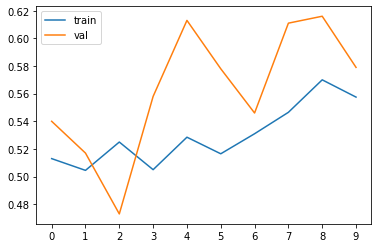

In [27]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

In [30]:
train_generator_2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds_2 = train_generator_2.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [31]:
validation_generator_2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_ds_2 = validation_generator_2.flow_from_directory(
    validation_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 5000 images belonging to 2 classes.


In [32]:
%%time

history_2 = model.fit(
    train_ds_2,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_ds_2,
    validation_steps=50
)

Epoch 1/10
100/100 [==============================] - 25s 255ms/step - loss: 0.6867 - accuracy: 0.5450 - val_loss: 0.6826 - val_accuracy: 0.5540
Epoch 2/10
100/100 [==============================] - 25s 250ms/step - loss: 0.6862 - accuracy: 0.5415 - val_loss: 0.6794 - val_accuracy: 0.5750
Epoch 3/10
100/100 [==============================] - 25s 248ms/step - loss: 0.6842 - accuracy: 0.5525 - val_loss: 0.6817 - val_accuracy: 0.5810
Epoch 4/10
100/100 [==============================] - 27s 273ms/step - loss: 0.6882 - accuracy: 0.5485 - val_loss: 0.6846 - val_accuracy: 0.5830
Epoch 5/10
100/100 [==============================] - 25s 252ms/step - loss: 0.6839 - accuracy: 0.5590 - val_loss: 0.6845 - val_accuracy: 0.5470
Epoch 6/10
100/100 [==============================] - 25s 252ms/step - loss: 0.6850 - accuracy: 0.5530 - val_loss: 0.6825 - val_accuracy: 0.5850
Epoch 7/10
100/100 [==============================] - 25s 255ms/step - loss: 0.6792 - accuracy: 0.5610 - val_loss: 0.6757 - val_ac

In [33]:
np.mean(history.history["val_loss"])

0.6866560399532318

In [40]:
np.mean(history.history["val_accuracy"][-5:])

0.5860000014305115